## Empty_places

In [1]:
import time
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt

In [22]:
class YOLOv8:
    """
    Модель YOLO, преобразованная в onnx формат
    """
    def __init__(self, path, conf_thres=0.7, iou_thres=0.5):
        self.conf_threshold = conf_thres
        self.iou_threshold = iou_thres

        # Инициализация модели
        self.initialize_model(path)

    def __call__(self, image):
        return self.detect_objects(image)

    def initialize_model(self, path):
        """
        Инициализация модели
        
        :param path: путь к модели
        """
        # Основной класс для запуска модели
        self.session = onnxruntime.InferenceSession(path,
                                                    providers=['CUDAExecutionProvider',
                                                               'CPUExecutionProvider'])
        # Получение информации о модели
        self.get_input_details()
        self.get_output_details()

    def detect_objects(self, image):
        """
        Детекция изображения
        
        :param image: np.array - прочитанное изображение в массив
        """
        input_tensor = self.prepare_input(image)

        # Результат предикции
        outputs = self.inference(input_tensor)

        self.boxes, self.scores, self.class_ids = self.process_output(outputs)

        return self.boxes, self.scores, self.class_ids

    def prepare_input(self, image):
        """
        Подготавливает изображение
        
        :param image: np.array - прочитанное изображение в массив
        """
        self.img_height, self.img_width = image.shape[:2]

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Ресайз изображения
        image = cv2.resize(image, (640, 640), interpolation=cv2.INTER_LINEAR)

        # Скалирование изображения
        image = image / 255.0
        image = image.transpose(2, 0, 1)
        input_tensor = image[np.newaxis, :, :, :].astype(np.float32)

        return input_tensor

    def inference(self, input_tensor):
        """
        Инференс модели
        
        :param input_tensor: np.array - подготовленное изображение
        """
        start = time.perf_counter()
        outputs = self.session.run(self.output_names, {self.input_names[0]: input_tensor})

        # print(f"Inference time: {(time.perf_counter() - start)*1000:.2f} ms")
        return outputs

    def process_output(self, output):
        """
        Подготовка результатов модели
        """
        predictions = np.squeeze(output[0]).T

        # Фильтрафия оценок, которые ниже уверенности модели
        scores = np.max(predictions[:, 4:], axis=1)
        predictions = predictions[scores > self.conf_threshold, :]
        scores = scores[scores > self.conf_threshold]

        if len(scores) == 0:
            return [], [], []

        # Класс с наибольшей уверенностью
        class_ids = np.argmax(predictions[:, 4:], axis=1)

        # Прямоугольники для каждого предсказания
        self.extract_boxes(predictions)

        # Применение метода nms
        indices = nms(self.boxes, scores, self.iou_threshold)

        return self.boxes[indices], scores[indices], class_ids[indices]

    def extract_boxes(self, predictions):
        """
        Извлечение прямоугольников
        """
        # Прямоугольники
        self.boxes = predictions[:, :4]
        # Рескалинг под разрешение изображения
        self.boxes = self.rescale_boxes(self.boxes)
        # Перевод в формат vol
        self.boxes = xywh2xyxy(self.boxes)
        

    def get_boxes(self):
        """
        Получить прямоугольники из экземпляра класса
        """
        return self.boxes

    def rescale_boxes(self, boxes):
        """
        Рескейл к исходному разрешению
        """
        input_shape = np.array([self.input_width, self.input_height,
                                self.input_width, self.input_height])
        boxes = np.divide(boxes, input_shape, dtype=np.float32)
        boxes *= np.array([self.img_width, self.img_height, self.img_width, self.img_height])
        return boxes

    def draw_detections(self, image):
        """
        Нанесение прямоугольников
        """
        class_names = ['Cable_drum']
        rng = np.random.default_rng(3)
        colors = rng.uniform(0, 255, size=(len(class_names), 3))
        
        # Прямоугольники
        for box, score, class_id in zip(self.boxes, self.scores, self.class_ids):
            color = colors[class_id]

            x_1, y_1, x_2, y_2 = box.astype(int)

            # Прямоугольник
            cv2.rectangle(image, (x_1, y_1), (x_2, y_2), color, 2)

            # Отображение лейблов
            label = class_names[class_id]
            caption = f'{label} {int(score * 100)}%'
                    
            # font
            font = cv2.FONT_HERSHEY_SIMPLEX
                    
            # fontScale
            fontScale = 1
            
            # Line thickness of 2 px
            thickness = 2
            
            # Using cv2.putText() method
            cv2.putText(image, caption, (x_1, y_1 - 4 * thickness),
                        font, fontScale, color, thickness, cv2.LINE_AA)        

        return image

    def get_input_details(self):
        """
        Получение информации из входных данных
        """
        model_inputs = self.session.get_inputs()
        self.input_names = [model_inputs[i].name for i in range(len(model_inputs))]

        self.input_shape = model_inputs[0].shape
        self.input_height = self.input_shape[2]
        self.input_width = self.input_shape[3]

    def get_output_details(self):
        """
        Информация о выходных значениях
        """
        model_outputs = self.session.get_outputs()
        self.output_names = [model_outputs[i].name for i in range(len(model_outputs))]


In [3]:
# class_names = ['Cable_drum']

# rng = np.random.default_rng(3)
# colors = rng.uniform(0, 255, size=(len(class_names), 3))


def nms(boxes, scores, iou_threshold):
    """
    Алгоритм nms для удаления дублирующихся рамок
    """
    # Сортировка по значению предсказания
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Выбор последнего прямоугольника
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Вычисление метрики по сравнению с остальными
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Выбор боксов, у которых метрика не превышает порога
        keep_indices = np.where(ious < iou_threshold)[0]

        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes


def compute_iou(box, boxes):
    """
    Вычисление iou
    """
    # Выбор минимальных/максимальных значений
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Вычисление площади пересечения
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Площадь объединения
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Расчет IoU
    iou = intersection_area / union_area

    return iou


def xywh2xyxy(x):
    """
    Конвертация формата рамок из YOLO в VOC
    """
    # Конвертация (x, y, w, h) в (x1, y1, x2, y2)
    # Из yolo формата в VOC
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y



In [4]:
def onnx_detect_image(image_path):
    """
    Запуск модели
    """
    model_path = r'train4\weights\best.onnx'
    yolov8_detector = YOLOv8(path=model_path,
                             conf_thres=0.3,
                             iou_thres=0.5)

    img = cv2.imread(image_path)
    
    yolov8_detector(img)
    detected_img = yolov8_detector.draw_detections(img)
    
    # plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))

    cv2.namedWindow("Output", cv2.WINDOW_NORMAL)    
    cv2.imshow("Output", detected_img)    
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def onnx_detect_video():
    """
    Запуск модели
    """
    # Захват видео с камеры
    cap = cv2.VideoCapture(0)

    model_path = r'train4\weights\best.onnx'
    yolov8_detector = YOLOv8(path=model_path,
                             conf_thres=0.3,
                             iou_thres=0.5)

    cv2.namedWindow("Detected Objects", cv2.WINDOW_NORMAL)
    
    while cap.isOpened():

        # Кадр с камеры
        ret, frame = cap.read()

        if not ret:
            break

        # Детектирование
        yolov8_detector(frame)
        detected_img = yolov8_detector.draw_detections(frame)

        # plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))

        cv2.imshow("Detected Objects", detected_img)

        # Для выхода нажать q
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

In [10]:
onnx_detect_video()

c:\Users\rapto\AppData\Local\Programs\Python\Python310\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [12]:
cap = cv2.VideoCapture(0)

In [26]:
model_path = r'train4\weights\best.onnx'
yolov8_detector = YOLOv8(path=model_path,
                             conf_thres=0.3,
                             iou_thres=0.5)

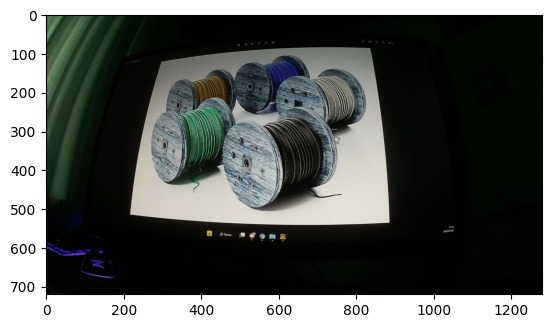

In [71]:
ret, frame = cap.read()

# cv2.imshow('window_name', frame)
# cv2.waitKey(0)
# # closing all open windows
# cv2.destroyAllWindows()

plt.imshow(frame)

In [72]:
yolov8_detector(frame)
detected_img = yolov8_detector.draw_detections(frame)

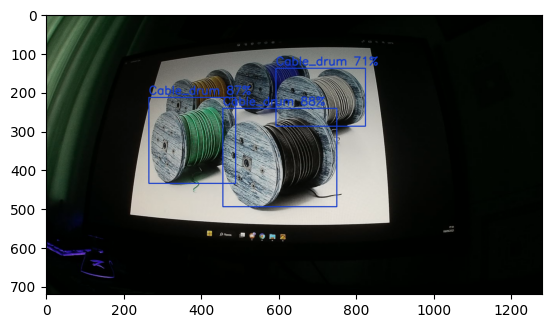

In [73]:
plt.imshow(detected_img)
# plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))

In [76]:
boxes = yolov8_detector.get_boxes()
boxes

array([[456.74512, 242.63786, 750.88855, 495.18005],
       [265.4324 , 214.67471, 489.11093, 435.78366],
       [593.3921 , 139.03238, 824.     , 288.09982]], dtype=float32)

In [203]:
keep_indices = []

for box in boxes:
    ious = compute_iou(box, boxes)
    print(ious)
    # keep_indices = np.append(keep_indices, np.where(ious < 0.16)[0], axis = 0)
    keep_indices.append(np.where(ious < 0.16)[0].tolist())
    # for iou in ious:        
    #     if iou > 0.16:
    #         print()
    
keep_indices
# np.array(keep_indices)

[1.         0.05320742 0.07054307]
[0.05320742 1.         0.        ]
[0.07054307 0.         1.        ]


[[1, 2], [0, 2], [0, 1]]

In [9]:
onnx_detect_image(r'C:\ML\cabledrums\cabledrums_dataset\train\images\1aa35d50-2.jpg')